# Notebook to reproduce 14 Her c NIRCam imaging with the 335R coronagraph

Author: W. Balmer (May 20th, 2025)

This notebook should allow the user to reproduce the data reduction, starlight subtraction, contrast calibration, and source extraction for JWST GO 3337 (DBG & Balmer et al. 2025)

# install pyklip, spaceklip, etc

To run this notebook, you'll need to create a new conda environment and install stpsf, pyklip, spaceklip, etc and then open this notebook with a ipykernel based in that environment with the correct environment variables.

Download the spaceklip git repo:
```
git clone https://github.com/spacetelescope/spaceKLIP.git
```
Create a new env with the right python version:
```
conda create -n spaceklip_v2p1 python=3.11
conda activate spaceklip_v2p1
```

(optionally, you can create a jupyter kernel, and run this notebook on that kernel explicitly):

```
pip install ipykernel
python -m ipykernel install --user --name=spaceklip_v2p1
```

Cd into the repo, checkout the version of spaceklip that was used for the paper (v2.1), install the requirements, and finally install spaceklip itself.
```
cd spaceKLIP
git checkout 11df3a1
pip install jwst==1.18
pip install -r requirements.txt
pip install -e .
```

In the paper, we used CRDS_VER='12.1.5  ' and the 'jwst_1364.pmap' CRDS context.

Download the stpsf reference files from [here](https://stpsf.readthedocs.io/en/latest/installation.html) and set up the correct environment variables, for example:
```
export STPSF_PATH=$HOME/data/stpsf-data
export WEBBPSF_EXT_PATH='$HOME/data/webbpsf_ext_data/'
export PYSYN_CDBS='$HOME/data/cdbs/'
```

In [1]:
target='14Her'
pid=3337

# acquire data

To aquire nircam coron data, you can use the jwst_mast_query or spaceklip.mast api tools:

https://github.com/spacetelescope/jwst_mast_query

jwst_download.py -v --instrument nircam --propID 1193 -f uncal.fits --date_select 2022-01-01 2022-12-01

In [2]:
from spaceKLIP import mast
import numpy as np

In [3]:
data_dir = f'/Users/wbalmer/data/jwst/{target}/' # edit this to refer to your own file structure

In [4]:
table = mast.query_coron_datasets('NIRCam', 
                                  'F444W', 
                                  'MASKA335R',
                                  program=pid,
                                  ignore_exclusive_access=False, 
                                  return_filenames=True, 
                                  level='uncal')

print(f"Found {len(table)} total rows.")
print(table[-5:-1])

Found 11 total rows.
                   filename                   ... publicReleaseDate_mjd
--------------------------------------------- ... ---------------------
jw03337003001_05101_00005_nrcalong_uncal.fits ...    60449.080104166664
jw03337003001_05101_00006_nrcalong_uncal.fits ...     60449.08042824074
jw03337003001_05101_00007_nrcalong_uncal.fits ...     60449.07983796296
jw03337003001_05101_00008_nrcalong_uncal.fits ...    60449.080104166664


In [5]:
mast.download_files(table, outputdir=data_dir)

 ALREADY DOWNLOADED: /Users/wbalmer/data/jwst/14Her/jw03337001001_05101_00001_nrcalong_uncal.fits
 ALREADY DOWNLOADED: /Users/wbalmer/data/jwst/14Her/jw03337002001_05101_00001_nrcalong_uncal.fits
 ALREADY DOWNLOADED: /Users/wbalmer/data/jwst/14Her/jw03337003001_05101_00001_nrcalong_uncal.fits
 ALREADY DOWNLOADED: /Users/wbalmer/data/jwst/14Her/jw03337003001_05101_00002_nrcalong_uncal.fits
 ALREADY DOWNLOADED: /Users/wbalmer/data/jwst/14Her/jw03337003001_05101_00003_nrcalong_uncal.fits
 ALREADY DOWNLOADED: /Users/wbalmer/data/jwst/14Her/jw03337003001_05101_00004_nrcalong_uncal.fits
 ALREADY DOWNLOADED: /Users/wbalmer/data/jwst/14Her/jw03337003001_05101_00005_nrcalong_uncal.fits
 ALREADY DOWNLOADED: /Users/wbalmer/data/jwst/14Her/jw03337003001_05101_00006_nrcalong_uncal.fits
 ALREADY DOWNLOADED: /Users/wbalmer/data/jwst/14Her/jw03337003001_05101_00007_nrcalong_uncal.fits
 ALREADY DOWNLOADED: /Users/wbalmer/data/jwst/14Her/jw03337003001_05101_00008_nrcalong_uncal.fits
 ALREADY DOWNLOADED:

# initialize spaceklip and database object

In [6]:
from __future__ import division

# =============================================================================
# IMPORTS
# =============================================================================

import os
import pdb
import sys

import astropy.io.fits as fits
import matplotlib.pyplot as plt
import numpy as np

from spaceKLIP import database, coron1pipeline, coron2pipeline, coron3pipeline, pyklippipeline, imagetools, analysistools

# plotting
import matplotlib.pyplot as plt

In [7]:
# Set the input and output directories and grab the input FITS files.

# are the data reduced yet?
reduced = False
# are the bad pixels corrected yet?
cleaned = False
# are the data aligned yet?
aligned = False

# extra options: defaults are those used in our paper
pad = False
coadd = False
crop = True
blur = True

data_dir = f'/Users/wbalmer/data/jwst/{target}/' # edit this to refer to your own file structure
output_dir = f'./spaceklip_{target}/' # edit this to refer to your own file structure

if aligned and coadd:
    input_dir = output_dir+'coadded/'
    fitsfiles = sorted([input_dir + f for f in os.listdir(input_dir) if f.endswith('calints.fits')])
elif aligned:
    input_dir = output_dir+'aligned/'
    fitsfiles = sorted([input_dir + f for f in os.listdir(input_dir) if f.endswith('calints.fits')])
elif cleaned:
    input_dir = output_dir+'medsub/'
    fitsfiles = sorted([input_dir + f for f in os.listdir(input_dir) if f.endswith('calints.fits')])
elif reduced:
    input_dir = output_dir+'stage2/'
    fitsfiles = sorted([input_dir + f for f in os.listdir(input_dir) if f.endswith('.fits')])
else:
    input_dir = data_dir # pull uncal files from the directory jwst_mast_query downloads to (you might need to rename this)
    fitsfiles = sorted([input_dir + f for f in os.listdir(input_dir) if f.endswith('.fits')])

# spectral type of the star
spt = 'K0V' # 14 Her


# reductions

In [8]:
# Initialize the spaceKLIP database and read the input FITS files.
Database = database.Database(output_dir=output_dir)
Database.read_jwst_s012_data(datapaths=fitsfiles,
                             psflibpaths=None,
                             bgpaths=None)

[spaceKLIP.database:WARNING] Output directory does not exist. Creating ./spaceklip_14Her/.
2025-05-20 19:53:29,695 - CRDS - INFO -  Calibration SW Found: jwst 1.18.0 (/Users/wbalmer/miniconda3/envs/spaceklip_v2p1/lib/python3.11/site-packages/jwst-1.18.0.dist-info)


[spaceKLIP.database:INFO] --> Identified 1 concatenation(s)
[spaceKLIP.database:INFO]   --> Concatenation 1: JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R
TYPE  EXP_TYPE DATAMODL TELESCOP ... PIXAR_SR BUNIT      ROLL_REF      BLURFWHM
---- --------- -------- -------- ... -------- ----- ------------------ --------
 SCI NRC_CORON   STAGE0     JWST ...      nan    DN 191.86708538519264      nan
 SCI NRC_CORON   STAGE0     JWST ...      nan    DN 181.86637989259057      nan
 REF NRC_CORON   STAGE0     JWST ...      nan    DN  184.2896952377736      nan
 REF NRC_CORON   STAGE0     JWST ...      nan    DN  184.2896942592324      nan
 REF NRC_CORON   STAGE0     JWST ...      nan    DN  184.2896988355383      nan
 REF NRC_CORON   STAGE0     JWST ...      nan    DN  184.2897047149797      nan
 REF NRC_CORON   STAGE0     JWST ...      nan    DN  184.2896993815347      nan
 REF NRC_CORON   STAGE0     JWST ...      nan    DN  184.2896962829864      nan
 REF NRC_CORON   STAGE0     JWST ..

In [9]:
Database.obs.keys()

dict_keys(['JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R'])

In [10]:
# To select a subset of obs you can downsize the dict as follows
# In the instructions to download the data via spaceklip.mast above, you'll only get the F444W 
# but using jwst_download you'll get both F200W, F444W, and some TAQ images. 

select_obs = [
              # 'JWST_NIRCAM_NRCA2_F200W_MASKRND_MASK335R_SUB320A335R',
              'JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R',
              ]

Database.obs = {k:Database.obs[k] for k in select_obs}

In [11]:
if not reduced:
    coron1pipeline.run_obs(database=Database,
                           steps={'group_scale': {'skip': False},
                              'dq_init': {'skip': False},
                              'saturation': {'n_pix_grow_sat': 1,
                                             'grow_diagonal': False},
                              'ipc': {'skip': True},
                              'superbias':{'skip': False},
                              'refpix': {'odd_even_columns': True,
                                         'odd_even_rows': True,
                                         'nlower': 4,
                                         'nupper': 4,
                                         'nleft': 4,
                                         'nright': 4,
                                         'nrow_off': 0,
                                         'ncol_off': 0},
                              'linearity': {'skip': False},
                              'dark_current': {'skip': True},
                              'persistence': {'skip': True},
                              'jump': {'rejection_threshold': 4.,
                                       'three_group_rejection_threshold': 4.,
                                       'four_group_rejection_threshold': 4.,
                                       'maximum_cores': 'all'},
                              'subtract_1overf': {'model_type': 'median', # <--- this is not default
                                                  'sat_frac': 0.5,
                                                  'combine_ints': True,
                                                  'vertical_corr': True,
                                                  'nproc': 16
                                                 },
                              'ramp_fit': {
                                           'algorithm':'LIKELY', # <--- this is not default
                                           'save_calibrated_ramp': False,
                                           'maximum_cores': 'all'},
                              'gain_scale': {'skip': False}},
                           subdir='stage1')

[spaceKLIP.coron1pipeline:INFO] --> Concatenation JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R
[spaceKLIP.coron1pipeline:INFO]   --> Coron1Pipeline: processing jw03337001001_05101_00001_nrcalong_uncal.fits
[spaceKLIP.coron1pipeline:INFO]   --> Coron1Pipeline: processing jw03337002001_05101_00001_nrcalong_uncal.fits
[spaceKLIP.coron1pipeline:INFO]   --> Coron1Pipeline: processing jw03337003001_05101_00001_nrcalong_uncal.fits
[spaceKLIP.coron1pipeline:INFO]   --> Coron1Pipeline: processing jw03337003001_05101_00002_nrcalong_uncal.fits
[spaceKLIP.coron1pipeline:INFO]   --> Coron1Pipeline: processing jw03337003001_05101_00003_nrcalong_uncal.fits
[spaceKLIP.coron1pipeline:INFO]   --> Coron1Pipeline: processing jw03337003001_05101_00004_nrcalong_uncal.fits
[spaceKLIP.coron1pipeline:INFO]   --> Coron1Pipeline: processing jw03337003001_05101_00005_nrcalong_uncal.fits
[spaceKLIP.coron1pipeline:INFO]   --> Coron1Pipeline: processing jw03337003001_05101_00006_nrcalong_uncal.fits
[space

In [12]:
if not reduced:
    coron2pipeline.run_obs(database=Database,
                           steps={'outlier_detection': {'skip': False}},
                           subdir='stage2')

[spaceKLIP.coron2pipeline:INFO] --> Concatenation JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R
[spaceKLIP.coron2pipeline:INFO]   --> Coron2Pipeline: processing jw03337001001_05101_00001_nrcalong_rateints.fits
[spaceKLIP.coron2pipeline:INFO]   --> Coron2Pipeline: processing jw03337002001_05101_00001_nrcalong_rateints.fits
[spaceKLIP.coron2pipeline:INFO]   --> Coron2Pipeline: processing jw03337003001_05101_00001_nrcalong_rateints.fits
[spaceKLIP.coron2pipeline:INFO]   --> Coron2Pipeline: processing jw03337003001_05101_00002_nrcalong_rateints.fits
[spaceKLIP.coron2pipeline:INFO]   --> Coron2Pipeline: processing jw03337003001_05101_00003_nrcalong_rateints.fits
[spaceKLIP.coron2pipeline:INFO]   --> Coron2Pipeline: processing jw03337003001_05101_00004_nrcalong_rateints.fits
[spaceKLIP.coron2pipeline:INFO]   --> Coron2Pipeline: processing jw03337003001_05101_00005_nrcalong_rateints.fits
[spaceKLIP.coron2pipeline:INFO]   --> Coron2Pipeline: processing jw03337003001_05101_00006_nrcal

In [13]:
ImageTools = imagetools.ImageTools(Database)

In [14]:
if not cleaned:
    ImageTools.update_nircam_centers()

[spaceKLIP.imagetools:INFO] --> Concatenation JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R
[spaceKLIP.imagetools:INFO]   --> Update NIRCam coronagraphy centers: jw03337001001_05101_00001_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> Update NIRCam coronagraphy centers: using CRPIX from database
[spaceKLIP.imagetools:INFO]   --> Update NIRCam coronagraphy centers: old = (150.20, 174.60), new = (150.38, 174.39)
[spaceKLIP.imagetools:INFO]   --> Update NIRCam coronagraphy centers: jw03337002001_05101_00001_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> Update NIRCam coronagraphy centers: using CRPIX from database
[spaceKLIP.imagetools:INFO]   --> Update NIRCam coronagraphy centers: old = (150.20, 174.60), new = (150.38, 174.39)
[spaceKLIP.imagetools:INFO]   --> Update NIRCam coronagraphy centers: jw03337003001_05101_00001_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> Update NIRCam coronagraphy centers: using CRPIX from database
[spaceKLIP.imagetools:

[spaceKLIP.imagetools:INFO] --> Concatenation JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R
[spaceKLIP.imagetools:INFO]   --> Method dqarr: jw03337001001_05101_00001_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> Method sigclip: jw03337001001_05101_00001_nrcalong_calints.fits


[py.warnings:WARNING] /Users/wbalmer/spaceKLIP/spaceKLIP/imagetools.py:1531: RuntimeWarning: All-NaN slice encountered
  data_med = np.nanmedian(data_arr_trim, axis=0)

[py.warnings:WARNING] /Users/wbalmer/miniconda3/envs/spaceklip_v2p1/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,



Frame 96/96, iteration 5
[spaceKLIP.imagetools:INFO]   --> Method sigclip: identified 1291595 additional bad pixel(s) -- 13.14%


[py.warnings:WARNING] /Users/wbalmer/spaceKLIP/spaceKLIP/imagetools.py:1620: RuntimeWarning: All-NaN slice encountered
  med_ints = np.nanmedian(data_temp, axis=0)

[py.warnings:WARNING] /Users/wbalmer/miniconda3/envs/spaceklip_v2p1/lib/python3.11/site-packages/webbpsf_ext/robust.py:78: RuntimeWarning: All-NaN slice encountered
  med = medfunc(data, axis=axis, keepdims=True)

[py.warnings:WARNING] /Users/wbalmer/miniconda3/envs/spaceklip_v2p1/lib/python3.11/site-packages/webbpsf_ext/robust.py:80: RuntimeWarning: All-NaN slice encountered
  sigma = medfunc(absdiff, axis=axis, keepdims=True)  / sig_scale

[py.warnings:WARNING] /Users/wbalmer/miniconda3/envs/spaceklip_v2p1/lib/python3.11/site-packages/webbpsf_ext/robust.py:85: RuntimeWarning: Mean of empty slice
  sigma[mask] = (meanfunc(absdiff, axis=axis, keepdims=True))[mask] / 0.8

[py.warnings:WARNING] /Users/wbalmer/spaceKLIP/spaceKLIP/imagetools.py:1625: RuntimeWarning: invalid value encountered in divide
  diff = np.abs((data_temp


[spaceKLIP.imagetools:INFO]   --> Method timeints: identified 10016 additional bad pixel(s) -- 0.10%
[spaceKLIP.imagetools:INFO]   --> Method dqarr: jw03337002001_05101_00001_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> Method sigclip: jw03337002001_05101_00001_nrcalong_calints.fits
Frame 96/96, iteration 4
[spaceKLIP.imagetools:INFO]   --> Method sigclip: identified 1291125 additional bad pixel(s) -- 13.13%

[spaceKLIP.imagetools:INFO]   --> Method timeints: identified 9091 additional bad pixel(s) -- 0.09%
[spaceKLIP.imagetools:INFO]   --> Method dqarr: jw03337003001_05101_00001_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> Method sigclip: jw03337003001_05101_00001_nrcalong_calints.fits
Frame 16/16, iteration 3
[spaceKLIP.imagetools:INFO]   --> Method sigclip: identified 191441 additional bad pixel(s) -- 11.68%

[spaceKLIP.imagetools:INFO]   --> Method timeints: identified 9857 additional bad pixel(s) -- 0.60%
[spaceKLIP.imagetools:INFO]   --> Method dqarr: jw033

[py.warnings:WARNING] /Users/wbalmer/spaceKLIP/spaceKLIP/imagetools.py:1808: RuntimeWarning: All-NaN slice encountered
  data[ww_not_all_bad] = np.array([np.nanmedian(data, axis=0)] * data.shape[0])[ww_not_all_bad]

[py.warnings:WARNING] /Users/wbalmer/spaceKLIP/spaceKLIP/imagetools.py:1810: RuntimeWarning: All-NaN slice encountered
  erro[ww_not_all_bad] = np.array([np.nanmedian(erro, axis=0)] * erro.shape[0])[ww_not_all_bad]



[spaceKLIP.imagetools:INFO]   --> Method interp2d: jw03337001001_05101_00001_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> Method interp2d: fixing 105216 bad pixel(s) -- 1.07%
[spaceKLIP.imagetools:INFO]   --> Method timemed: jw03337002001_05101_00001_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> Method timemed: fixing 1300220 bad pixel(s) -- 13.23%
[spaceKLIP.imagetools:INFO]   --> Method interp2d: jw03337002001_05101_00001_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> Method interp2d: fixing 105312 bad pixel(s) -- 1.07%
[spaceKLIP.imagetools:INFO]   --> Method timemed: jw03337003001_05101_00001_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> Method timemed: fixing 201132 bad pixel(s) -- 12.28%
[spaceKLIP.imagetools:INFO]   --> Method interp2d: jw03337003001_05101_00001_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> Method interp2d: fixing 17712 bad pixel(s) -- 1.08%
[spaceKLIP.imagetools:INFO]   --> Method timemed: jw03337003001_05101_00

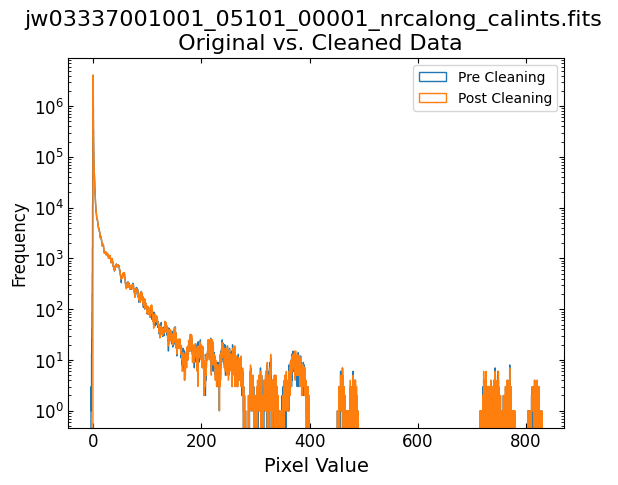

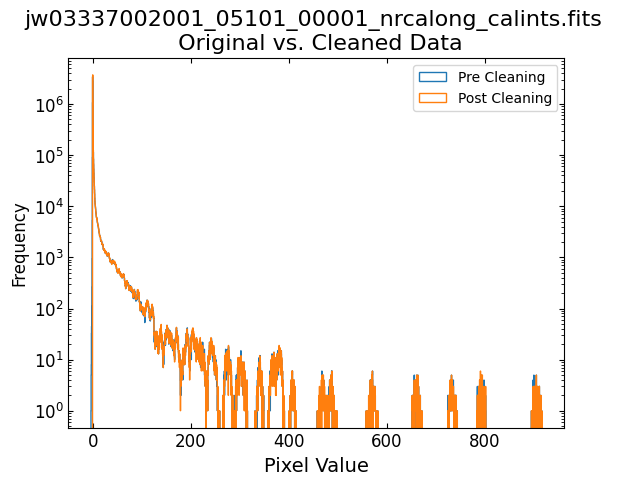

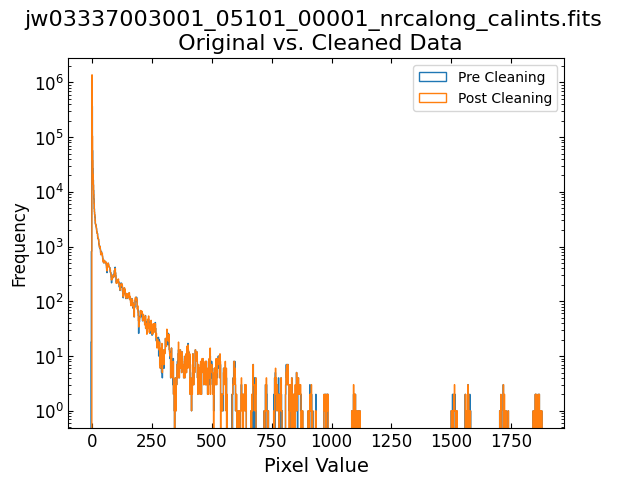

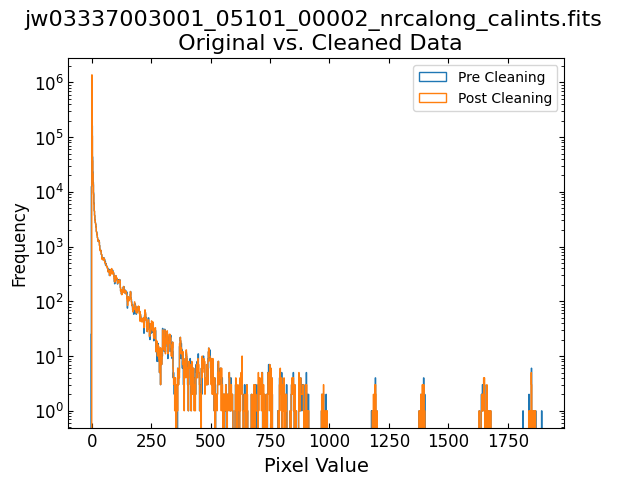

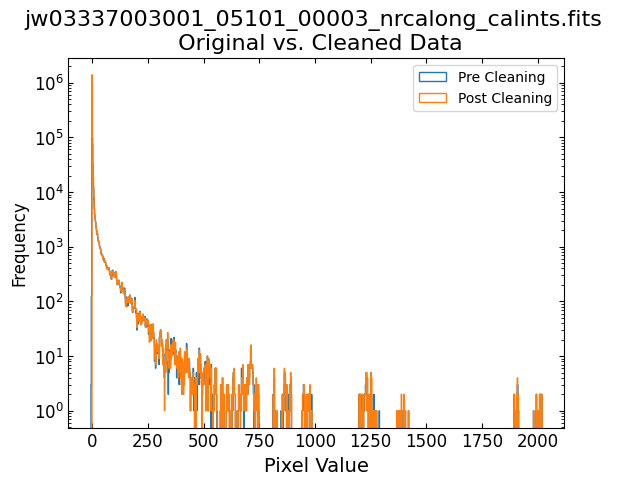

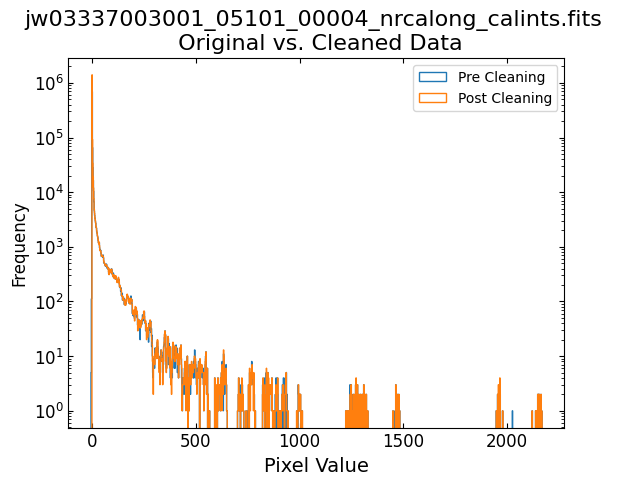

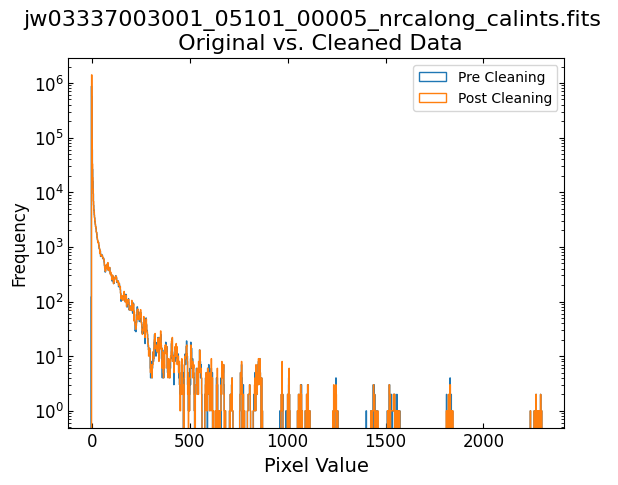

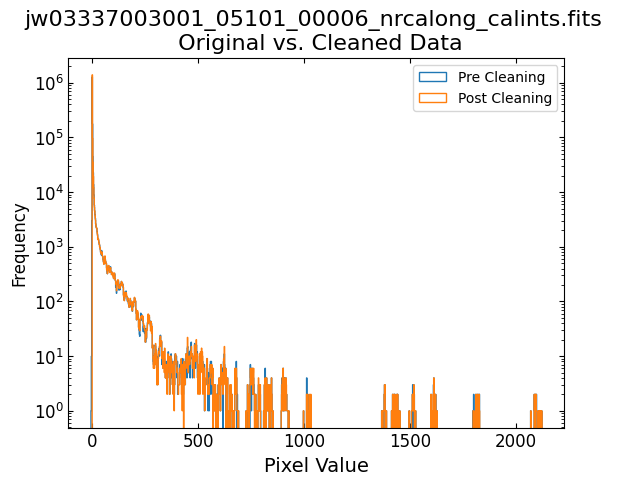

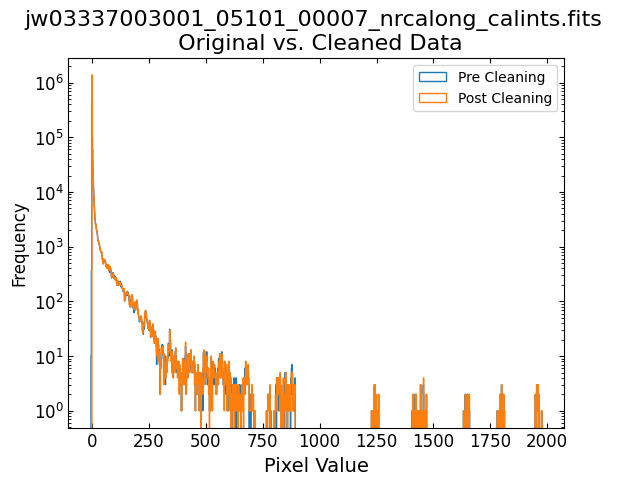

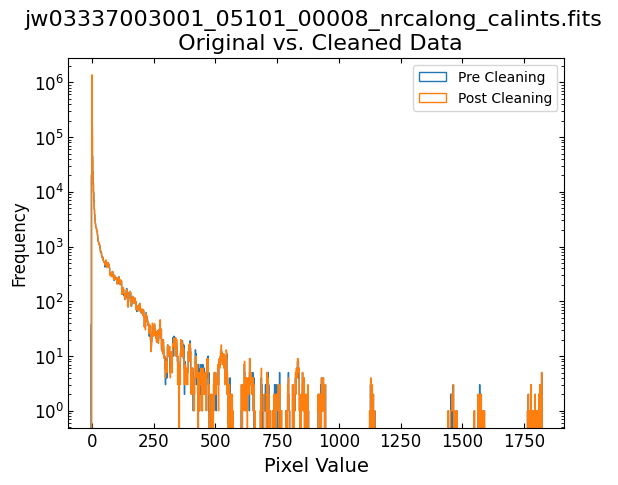

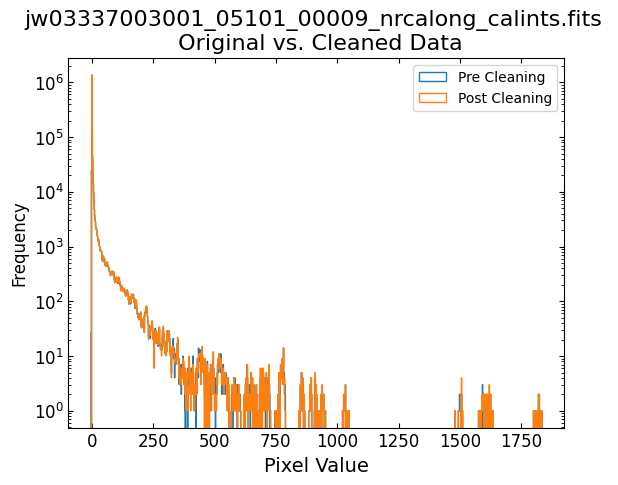

In [15]:
if not cleaned:
    ImageTools.find_bad_pixels(method='dqarr+sigclip+timeints',
                               sigclip_kwargs={'sigclip': 4,
                                               'shift_x': [-1, 0, 1],
                                               'shift_y': [-1, 0, 1]},
                               timeints_kwargs={'sigma':4}
                              )
    ImageTools.clean_bad_pixels(method='timemed+interp2d',
                                interp2d_kwargs={'size':9}, # default 4
                                subdir='bpcleaned')

In [16]:
if not cleaned:
    ImageTools.replace_nans(cval=0.,
                            types=['SCI', 'SCI_BG', 'REF', 'REF_BG'],
                            subdir='nanreplaced')

if not cleaned:
    ImageTools.subtract_median(types=['SCI', 'SCI_TA', 'SCI_BG', 'REF', 'REF_TA', 'REF_BG'],
                               subdir='medsub')

[spaceKLIP.imagetools:INFO] --> Concatenation JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R
[spaceKLIP.imagetools:INFO]   --> Nan replacement: jw03337001001_05101_00001_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> Nan replacement: replaced 0 nan pixel(s) with value 0.0 -- 0.00%
[spaceKLIP.imagetools:INFO]   --> Nan replacement: jw03337002001_05101_00001_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> Nan replacement: replaced 0 nan pixel(s) with value 0.0 -- 0.00%
[spaceKLIP.imagetools:INFO]   --> Nan replacement: jw03337003001_05101_00001_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> Nan replacement: replaced 0 nan pixel(s) with value 0.0 -- 0.00%
[spaceKLIP.imagetools:INFO]   --> Nan replacement: jw03337003001_05101_00002_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> Nan replacement: replaced 0 nan pixel(s) with value 0.0 -- 0.00%
[spaceKLIP.imagetools:INFO]   --> Nan replacement: jw03337003001_05101_00003_nrcalong_calints.fits
[spaceK

In [17]:
if not cleaned and coadd:
    ImageTools.coadd_frames()

[spaceKLIP.imagetools:INFO] --> Concatenation JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R
[spaceKLIP.imagetools:INFO]   --> Recenter frames: jw03337001001_05101_00001_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> Recenter frames: generating WebbPSF image for absolute centering (this might take a while)
[spaceKLIP.psf:INFO] Generating on-axis and off-axis PSFs...


[py.warnings:WARNING] /Users/wbalmer/miniconda3/envs/spaceklip_v2p1/lib/python3.11/site-packages/poppy/optics.py:465: DeprecationWarning: JWST NIRCam specific functionality in poppy.BandLimitedCoron is moving to webbpsf.NIRCam_BandLimitedCoron. The "nircamwedge" and "nircamcircular" options in poppy will be removed in a future version of poppy.
  warnings.warn('JWST NIRCam specific functionality in poppy.BandLimitedCoron is moving to ' +



[spaceKLIP.psf:INFO]   Done.
[spaceKLIP.imagetools:INFO]   --> Recenter frames: star offset between frame 0 and coronagraph center (dx, dy) = (-0.014, 0.107) pix
[spaceKLIP.imagetools:INFO]   --> Recenter frames: star offset between frame 1 and coronagraph center (dx, dy) = (-0.003, 0.108) pix
[spaceKLIP.imagetools:INFO]   --> Recenter frames: star offset between frame 2 and coronagraph center (dx, dy) = (-0.010, 0.104) pix
[spaceKLIP.imagetools:INFO]   --> Recenter frames: star offset between frame 3 and coronagraph center (dx, dy) = (-0.012, 0.101) pix
[spaceKLIP.imagetools:INFO]   --> Recenter frames: star offset between frame 4 and coronagraph center (dx, dy) = (-0.011, 0.106) pix
[spaceKLIP.imagetools:INFO]   --> Recenter frames: star offset between frame 5 and coronagraph center (dx, dy) = (-0.006, 0.109) pix
[spaceKLIP.imagetools:INFO]   --> Recenter frames: star offset between frame 6 and coronagraph center (dx, dy) = (-0.007, 0.108) pix
[spaceKLIP.imagetools:INFO]   --> Recent

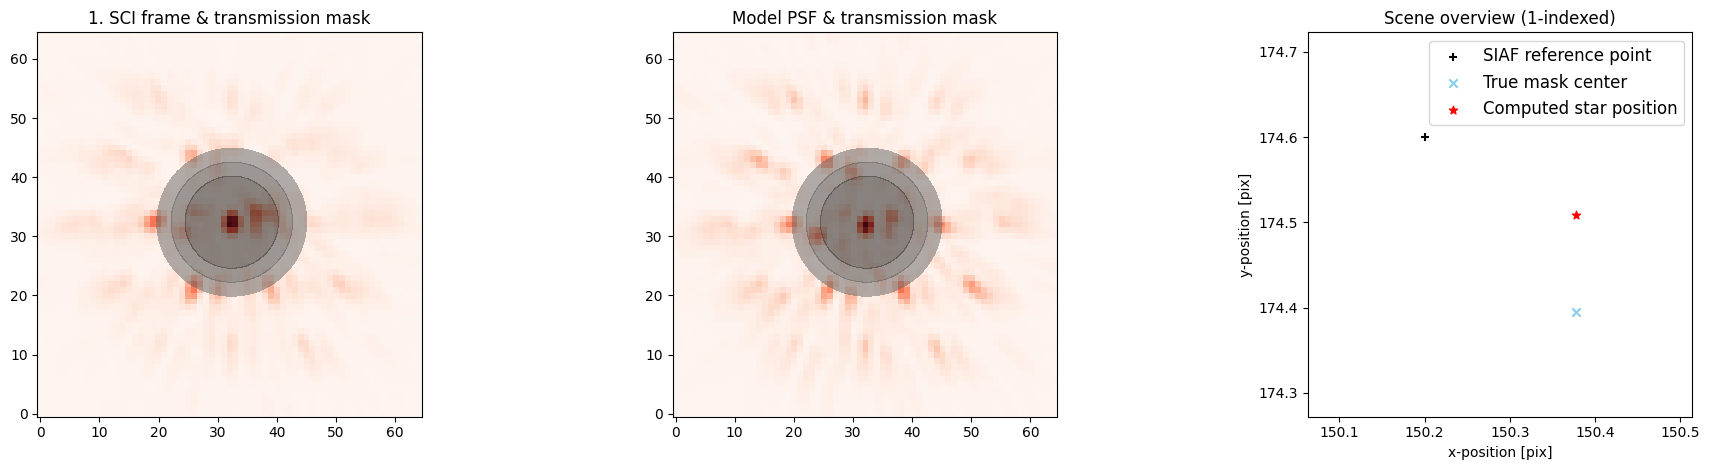

[spaceKLIP.imagetools:INFO]   --> Recenter frames: jw03337001001_05101_00001_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> Recenter frames: median required shift = 1078.92 mas
[spaceKLIP.imagetools:INFO]   --> Recenter frames: jw03337002001_05101_00001_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> Recenter frames: jw03337002001_05101_00001_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> Recenter frames: median required shift = 1078.92 mas
[spaceKLIP.imagetools:INFO]   --> Recenter frames: jw03337003001_05101_00001_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> Recenter frames: jw03337003001_05101_00001_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> Recenter frames: median required shift = 1078.92 mas
[spaceKLIP.imagetools:INFO]   --> Recenter frames: jw03337003001_05101_00002_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> Recenter frames: jw03337003001_05101_00002_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> Recenter fra

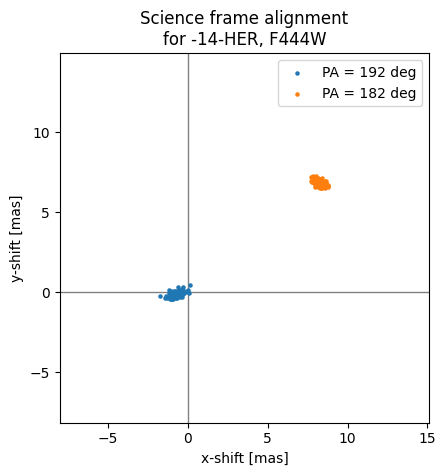

[spaceKLIP.imagetools:INFO]  Plot saved in ./spaceklip_14Her/aligned/JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R_align_ref.pdf


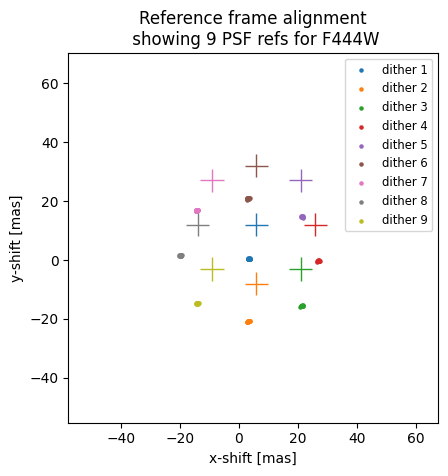

In [18]:
if not aligned:
    ImageTools.recenter_frames(
        spectral_type=spt,
    )

    if blur:
        ImageTools.blur_frames(subdir='blur')

    ImageTools.align_frames(
        subdir='aligned',
    )
    

In [19]:
if crop:
    ImageTools.crop_frames(npix=60) # from 320 -> 200

if pad:
    ImageTools.pad_frames(
                          npix=50,
                          types=['SCI', 'SCI_BG', 
                                 'REF', 'REF_BG'],
                          cval=0.
                         )

[spaceKLIP.imagetools:INFO] --> Concatenation JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R
[spaceKLIP.imagetools:INFO]   --> Frame cropping: jw03337001001_05101_00001_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> Frame cropping: old shape = (320, 320), new shape = (200, 200)
[spaceKLIP.imagetools:INFO]   --> Frame cropping: jw03337002001_05101_00001_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> Frame cropping: old shape = (320, 320), new shape = (200, 200)
[spaceKLIP.imagetools:INFO]   --> Frame cropping: jw03337003001_05101_00001_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> Frame cropping: old shape = (320, 320), new shape = (200, 200)
[spaceKLIP.imagetools:INFO]   --> Frame cropping: jw03337003001_05101_00002_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> Frame cropping: old shape = (320, 320), new shape = (200, 200)
[spaceKLIP.imagetools:INFO]   --> Frame cropping: jw03337003001_05101_00003_nrcalong_calints.fits
[spaceKLIP.imagetool

In [20]:
maxnumbasis = Database.obs['JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R']['NINTS'].sum()

In [21]:
numbasis = [1, 2, 3, 4, 5, 6, 7, 8, 9] + list(np.arange(10,maxnumbasis,10))

# klip

In [22]:
# this cell is only necessary if you have an apple silicon chip
# unfortunately, I have an apple silicon chip.
# once other image reduction steps are done, run this so that pyklip.parallelized doesn't break
# see discussion here: https://pyklip.readthedocs.io/en/latest/install.html#note-on-parallelized-performance
import platform
if platform.processor() == 'arm':
    os.environ["OPENBLAS_NUM_THREADS"] = "1"
    os.environ["OMP_NUM_THREADS"] = "1" 

In [23]:
pyklippipeline.run_obs(database=Database,
                       kwargs={'mode': ['ADI+RDI'],
                               'annuli': [1],
                               'subsections': [1],
                               'numbasis':numbasis,
                               'algo': 'klip'},
                       subdir='klipsub')

[spaceKLIP.pyklippipeline:INFO] --> Concatenation JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R


[py.warnings:WARNING] /Users/wbalmer/miniconda3/envs/spaceklip_v2p1/lib/python3.11/site-packages/astropy/wcs/wcs.py:805: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to   -97.058190 from OBSGEO-[XYZ].
Set OBSGEO-B to   -28.682882 from OBSGEO-[XYZ].
Set OBSGEO-H to 1654653499.189 from OBSGEO-[XYZ]'.
  warnings.warn(

[py.warnings:WARNING] /Users/wbalmer/miniconda3/envs/spaceklip_v2p1/lib/python3.11/site-packages/astropy/wcs/wcs.py:805: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to   -97.010576 from OBSGEO-[XYZ].
Set OBSGEO-B to   -28.716859 from OBSGEO-[XYZ].
Set OBSGEO-H to 1655202083.439 from OBSGEO-[XYZ]'.
  warnings.warn(



[spaceKLIP.pyklippipeline:INFO]   --> pyKLIP: mode = ADI+RDI, annuli = 1, subsections = 1
Begin align and scale images for each wavelength
Wavelength 4.439e-06 with index 0 has finished align and scale. Queuing for KLIP
Total number of tasks for KLIP processing is 1


  0%|          | 0/1 [00:00<?, ?it/s]

Closing threadpool
Derotating Images...


[py.warnings:WARNING] /Users/wbalmer/miniconda3/envs/spaceklip_v2p1/lib/python3.11/threading.py:563: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/wbalmer/data/stpsf-data/MAST_JWST_WSS_OPDs/R2024051802-NRCA3_FP1-1.fits'>
  self._cond = Condition(Lock())



Writing Images to directory /Users/wbalmer/a_herculean_detection/spaceklip_14Her/klipsub
wavelength collapsing reduced data of shape (b, N, wv, y, x):(42, 192, 1, 200, 200)


[py.warnings:WARNING] /Users/wbalmer/miniconda3/envs/spaceklip_v2p1/lib/python3.11/site-packages/astropy/wcs/wcs.py:805: FITSFixedWarning: 'datfix' made the change 'Set DATE-BEG to '2024-05-18T19:21:58.689' from MJD-BEG.
Set DATE-AVG to '2024-05-18T20:04:44.385' from MJD-AVG.
Set DATE-END to '2024-05-18T20:47:30.081' from MJD-END'.
  warnings.warn(

[py.warnings:WARNING] /Users/wbalmer/miniconda3/envs/spaceklip_v2p1/lib/python3.11/site-packages/astropy/wcs/wcs.py:805: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to   -97.058190 from OBSGEO-[XYZ].
Set OBSGEO-B to   -28.682882 from OBSGEO-[XYZ].
Set OBSGEO-H to 1654653499.189 from OBSGEO-[XYZ]'.
  warnings.warn(



[spaceKLIP.database:INFO] --> Identified 1 concatenation(s)
[spaceKLIP.database:INFO]   --> Concatenation 1: JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R


[py.warnings:WARNING] /var/folders/z3/sbzzx8w10cx6yd_63fg3nngm0000gn/T/ipykernel_79747/3318174833.py:1: ResourceWarning: unclosed file <_io.BufferedReader name='./spaceklip_14Her/cropped/jw03337001001_05101_00001_nrcalong_calints_psfmask.fits'>
  pyklippipeline.run_obs(database=Database,



 TYPE   EXP_TYPE DATAMODL ... BUNIT       BLURFWHM    
------ --------- -------- ... ------ -----------------
PYKLIP NRC_CORON   STAGE3 ... MJy/sr 2.704092754236962


In [24]:
data = fits.getdata(Database.red['JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R']['FITSFILE'][-1])

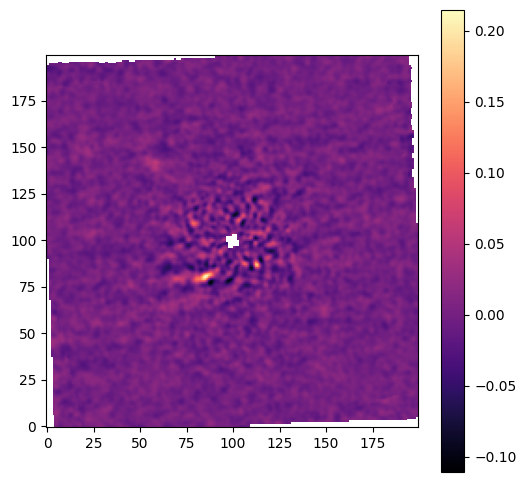

In [27]:
# display the starlight subtracted image:
plt.figure(figsize=(6,6))
plt.imshow(data[-1], origin='lower', cmap='magma')
plt.colorbar()

# analysis

In [28]:
Database = database.Database(output_dir=output_dir)
fitsfiles = sorted([output_dir+'klipsub/' + f for f in os.listdir(output_dir+'klipsub/') if f.endswith('KLmodes-all.fits')])
Database.read_jwst_s3_data(fitsfiles)

[spaceKLIP.database:INFO] --> Identified 1 concatenation(s)
[spaceKLIP.database:INFO]   --> Concatenation 1: JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R
 TYPE   EXP_TYPE DATAMODL ... BUNIT       BLURFWHM    
------ --------- -------- ... ------ -----------------
PYKLIP NRC_CORON   STAGE3 ... MJy/sr 2.704092754236962


In [29]:
# compute raw contrast curve?
raw_contrasts = True
# calibrate said curve?
calib_contrasts = True
# extract sources?
comp_fm = True

In [30]:
Analysis = analysistools.AnalysisTools(Database)

companions = [
    [-0.806, -0.758, 1e-6] # 14 Her c
             ] # units arcsecond, arcsecond, contrast

companion_masks = [
    [-0.806, -0.758, 1.5], [0.95, -1.25, 3.5] # 14 Her c and bg galaxy
] # units arcsecond, arcsecond, contrast

if companions == []:
    print('no comps')
    companions = None

if companion_masks == []:
    print('no comps masks')
    companion_masks = None


starfile = './14HERA_BTNEXTGEN_SCALED_MU_JY.txt'

[spaceKLIP.analysistools:INFO] Copying starfile ./14HERA_BTNEXTGEN_SCALED_MU_JY.txt to ./spaceklip_14Her/rawcon/14HERA_BTNEXTGEN_SCALED_MU_JY.txt
[spaceKLIP.analysistools:INFO] --> Concatenation JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R
[spaceKLIP.analysistools:INFO] Analyzing file ./spaceklip_14Her/klipsub/ADI+RDI_NANNU1_NSUBS1_JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R-KLmodes-all.fits


[py.warnings:WARNING] /Users/wbalmer/spaceKLIP/spaceKLIP/starphot.py:204: DeprecationWarning: open_text is deprecated. Use files() instead. Refer to https://importlib-resources.readthedocs.io/en/latest/using.html#migrating-from-legacy for migration advice.
  with importlib.resources.open_text(f'spaceKLIP.resources.PCEs.{instrume}', f'{filt}.txt') as bandpass_file:

[py.warnings:WARNING] /Users/wbalmer/spaceKLIP/spaceKLIP/starphot.py:204: DeprecationWarning: open_text is deprecated. Use files() instead. Refer to https://importlib-resources.readthedocs.io/en/latest/using.html#migrating-from-legacy for migration advice.
  with importlib.resources.open_text(f'spaceKLIP.resources.PCEs.{instrume}', f'{filt}.txt') as bandpass_file:

[py.warnings:WARNING] /Users/wbalmer/spaceKLIP/spaceKLIP/starphot.py:204: DeprecationWarning: open_text is deprecated. Use files() instead. Refer to https://importlib-resources.readthedocs.io/en/latest/using.html#migrating-from-legacy for migration advice.
  with 

[spaceKLIP.psf:INFO]   --> Generating WebbPSF model


[py.warnings:WARNING] /Users/wbalmer/miniconda3/envs/spaceklip_v2p1/lib/python3.11/site-packages/stpsf/detectors.py:62: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/wbalmer/data/stpsf-data/NIRCam/IPC/KERNEL_IPC_CUBE.fits'>
  kernel_ipc = CustomKernel(fits.open(sca_path)[det2sca[det]].data[0])  # we read the first slice in the cube

[py.warnings:WARNING] /Users/wbalmer/miniconda3/envs/spaceklip_v2p1/lib/python3.11/site-packages/stpsf/detectors.py:69: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/wbalmer/data/stpsf-data/NIRCam/IPC/KERNEL_PPC_CUBE.fits'>
  kernel_ppc = CustomKernel(fits.open(sca_path_ppc)[det2sca[det]].data[0])  # we read the first slice in the cube



[spaceKLIP.analysistools:INFO]   Masking out 2 known companions using provided parameters.
[spaceKLIP.analysistools:INFO]   Measuring raw contrast in annuli
[spaceKLIP.analysistools:INFO]   Measuring raw contrast for masked data
[spaceKLIP.analysistools:INFO]  Plot saved in ./spaceklip_14Her/rawcon/ADI+RDI_NANNU1_NSUBS1_JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R-KLmodes-all_masked.pdf


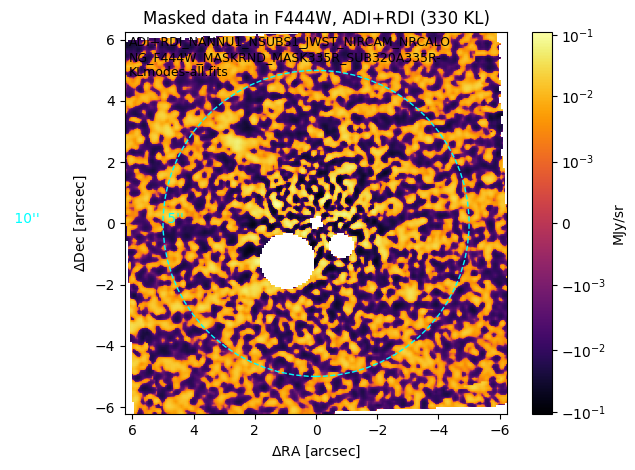

[spaceKLIP.analysistools:INFO]  Plot saved in ./spaceklip_14Her/rawcon/ADI+RDI_NANNU1_NSUBS1_JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R-KLmodes-all_rawcon.pdf


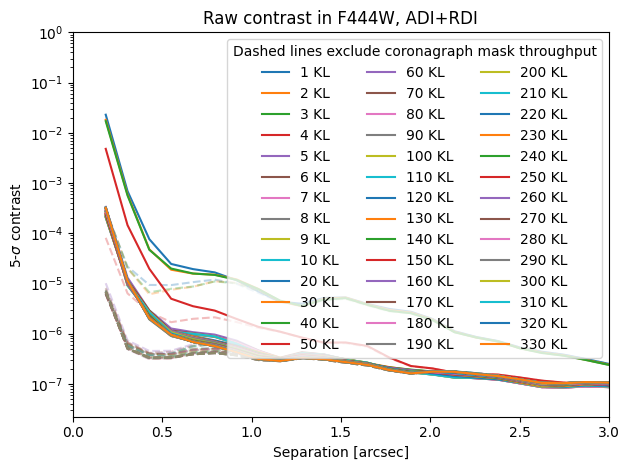

Contrast results and plots saved to ./spaceklip_14Her/rawcon/ADI+RDI_NANNU1_NSUBS1_JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R-KLmodes-all_seps.npy, ./spaceklip_14Her/rawcon/ADI+RDI_NANNU1_NSUBS1_JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R-KLmodes-all_cons.npy


In [31]:
if raw_contrasts:
    Analysis.raw_contrast(starfile,spectral_type=spt,companions=companion_masks, plot_xlim=(0,3))

In [9]:
inj_seps = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.5, 3.0]
if calib_contrasts:
    if companion_masks is not None:
        Analysis.calibrate_contrast(
                                    companions=companion_masks,
                                    injection_seps=inj_seps,
                                    plot_xlim=(0,3)
                                   )
    else:
        Analysis.calibrate_contrast(injection_seps=inj_seps,
                                    plot_xlim=(0,3)
                                   )

[spaceKLIP.analysistools:INFO] --> Concatenation JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R
[spaceKLIP.psf:INFO] Generating on-axis and off-axis PSFs...
[spaceKLIP.psf:INFO]   Done.
Begin align and scale images for each wavelength
Align and scale finished
Starting KLIP for sector 1/1 with an area of 125663.70614359173 pix^2
Time spent on last sector: 0s
Time spent since beginning: 0s
First sector: Can't predict remaining time

Closing threadpool
Writing KLIPed Images to directory /Users/wbalmer/reductions/jwst/misc_nircam_wide/spaceklip_14Her/companions/KL336/C1/KLIP_FM
[spaceKLIP.analysistools:INFO]   --> Initialized PlanetEvidence module
[spaceKLIP.analysistools:INFO]   --> Generated FM and data stamps
[spaceKLIP.analysistools:INFO]   --> Set fit kernel to matern32
[spaceKLIP.analysistools:INFO]   --> Set fit bounds
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 

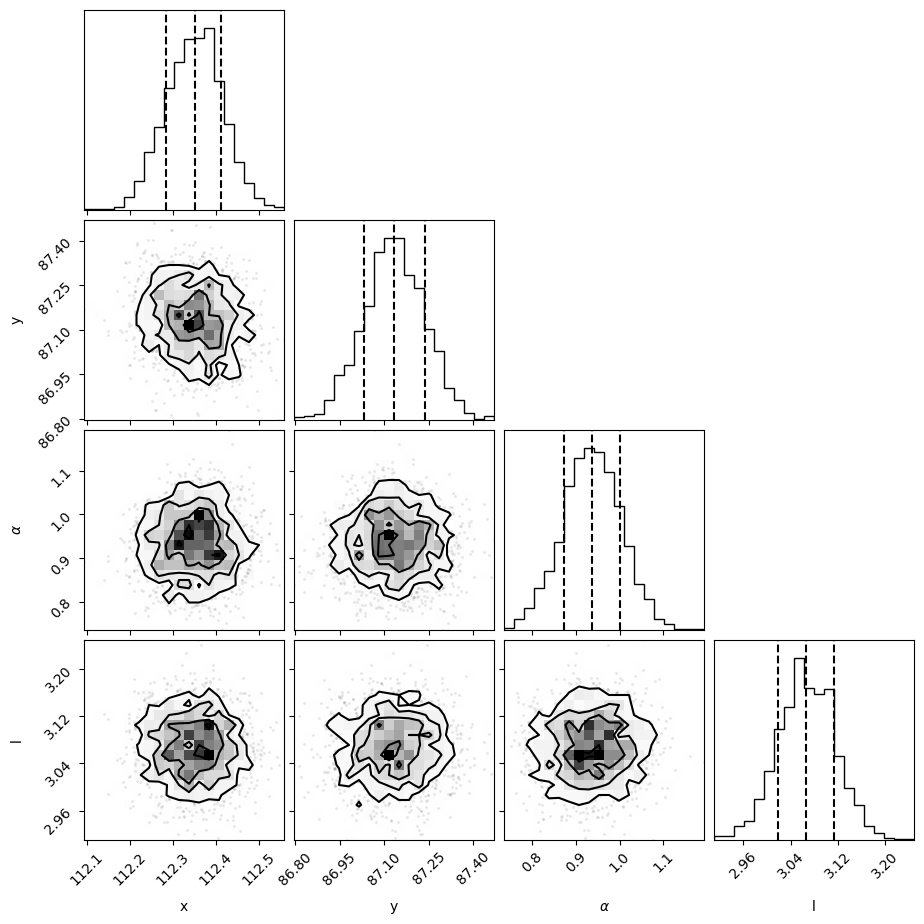

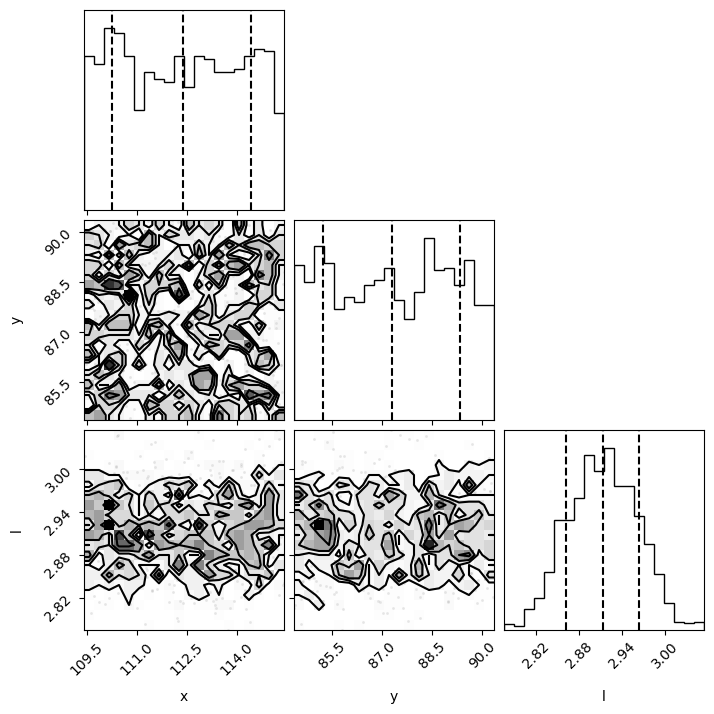

SNR from data stamp residuals: 5.778906133832995


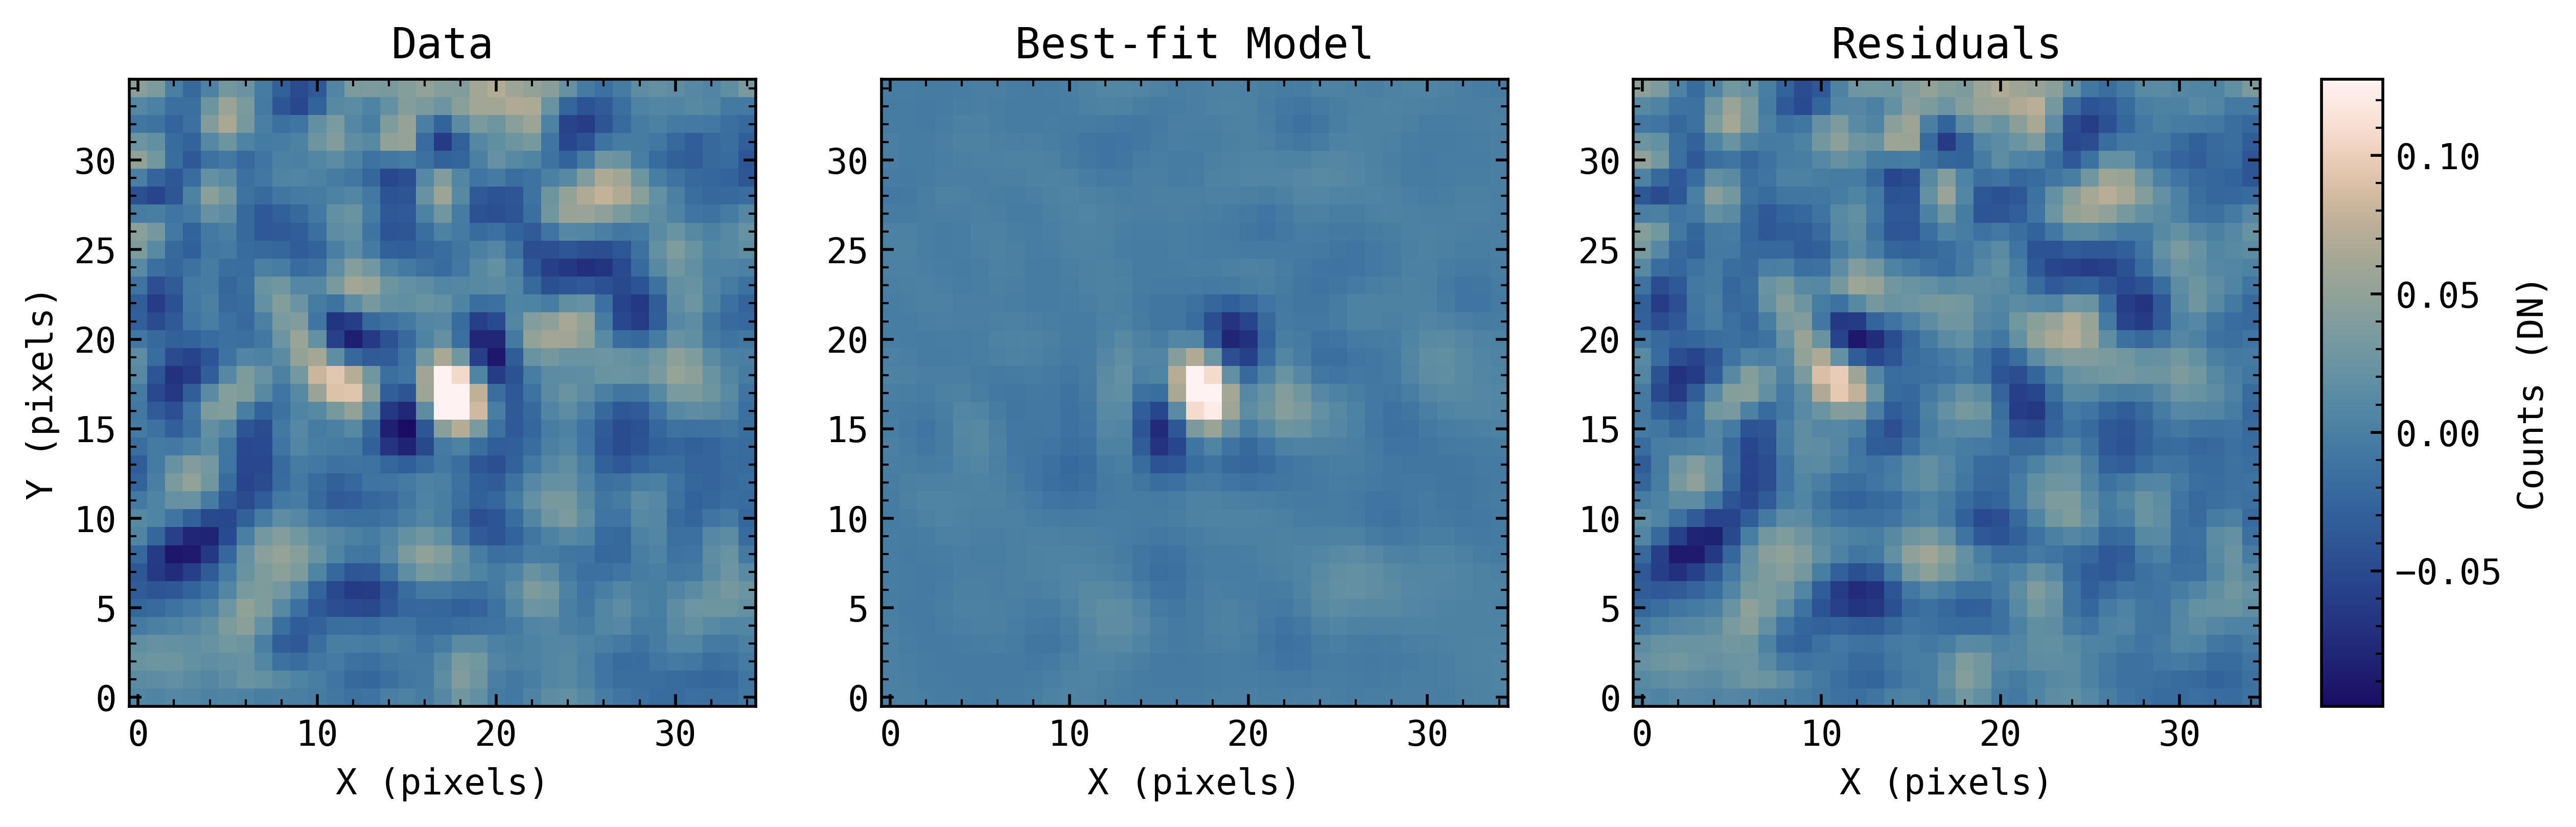

  0%|          | 0/1 [00:00<?, ?it/s]

Table saved to ./spaceklip_14Her/companions/KL336/C1/ADI+RDI_NANNU1_NSUBS1_JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R-results_c1.ecsv


In [10]:
if comp_fm:
    if companions is not None:
        Analysis.extract_companions(companions, 
                                    starfile,
                                    0.0,
                                    spectral_type=spt,
                                    planetfile='./14HER_PLANET_LACY23_SCALED_MU_JY.txt',
                                    fitmethod='mcmc',
                                    fitkernel='matern32',
                                    nthreads=16,
                                    subtract=True,
                                    save_preklip=False,
                                   )